# RO47019: Intelligent Control Systems Practical Assignment
* Period: 2022-2023, Q3
* Course homepage: https://brightspace.tudelft.nl/d2l/home/500969
* Instructor: Cosimo Della Santina (C.DellaSantina@tudelft.nl)
* Teaching assistant: Ruben Martin Rodriguez (R.MartinRodriguez@student.tudelft.nl)
* (c) TU Delft, 2023

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Remove `raise NotImplementedError()` afterwards. Moreover, if you see an empty cell, please DO NOT delete it, instead run that cell as you would run all other cells. Please fill in your name(s) and other required details below:

In [37]:
# Please fill in your names, student numbers, netID, and emails below.
# Please fill in your names, student numbers, netID, and emails below.
STUDENT_1_NAME = "Long, Youyuan"
STUDENT_1_STUDENT_NUMBER = "5690641"
STUDENT_1_NETID = "youyuanlong"
STUDENT_1_EMAIL = "Y.Long-2@student.tudelft.nl"

In [38]:
# Note: this block is a check that you have filled in the above information.
# It will throw an AssertionError until all fields are filled
assert STUDENT_1_NAME != ""
assert STUDENT_1_STUDENT_NUMBER != ""
assert STUDENT_1_NETID != ""
assert STUDENT_1_EMAIL != ""

### General announcements

* Do *not* share your solutions, and do *not* copy solutions from others. By submitting your solutions, you claim that you alone are responsible for this code.

* Do *not* email questions directly, since we want to provide everybody with the same information and avoid repeating the same answers. Instead, please post your questions regarding this assignment in the correct support forum on Brightspace, this way everybody can benefit from the response. If you do have a particular question that you want to ask directly, please use the scheduled Q&A hours to ask the TA.

* There is a strict deadline for each assignment. Students are responsible to ensure that they have uploaded their work in time. So, please double check that your upload succeeded to the Brightspace and avoid any late penalties.

* This [Jupyter notebook](https://jupyter.org/) uses `nbgrader` to help us with automated tests. `nbgrader` will make various cells in this notebook "uneditable" or "unremovable" and gives them a special id in the cell metadata. This way, when we run our checks, the system will check the existence of the cell ids and verify the number of points and which checks must be run. While there are ways that you can edit the metadata and work around the restrictions to delete or modify these special cells, you should not do that since then our nbgrader backend will not be able to parse your notebook and give you points for the assignment. You are free to add additional cells, but if you find a cell that you cannot modify or remove, please know that this is on purpose.

* This notebook will have in various places a line that throws a `NotImplementedError` exception. These are locations where the assignment requires you to adapt the code! These lines are just there as a reminder for youthat you have not yet adapted that particular piece of code, especially when you execute all the cells. Once your solution code replaced these lines, it should accordingly *not* throw any exceptions anymore.

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

# Task 2b - Using sensing for control (10p)

**Author:** Maximilian Stölzle (M.W.Stolzle@tudelft.nl)

The goal of this task is to use the CNN model trained in Task 1.4 to estimate the link angles and then use these estimated link angles $\hat{\theta} \in \mathbb{R}^2$ for closed-loop control of the robot.

In [39]:
# Reloads the python files outside of this notebook automatically
%load_ext autoreload
%autoreload 2

# import all Python modules
import cv2
from distutils.util import strtobool
from functools import partial
from IPython.display import display, HTML  # For animations in the notebook
from jax.config import config as jax_config

jax_config.update("jax_platform_name", "cpu")  # set default device to 'cpu'
jax_config.update("jax_enable_x64", True)  # double precision
from jax import Array
from jax import numpy as jnp
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as onp
import os
from pathlib import Path
import torch
import torch.nn as nn
from tqdm.notebook import tqdm  # progress bar
from typing import Callable, Dict, Tuple

from jax_double_pendulum.analysis import *
from jax_double_pendulum.dynamics import discrete_forward_dynamics, dynamical_matrices
from jax_double_pendulum.kinematics import (
    forward_kinematics,
    extended_forward_kinematics,
)
from jax_double_pendulum.motion_planning import (
    generate_ellipse_trajectory,
    ELLIPSE_PARAMS,
)
from jax_double_pendulum.robot_parameters import ROBOT_PARAMS
from jax_double_pendulum.robot_simulation import simulate_robot
from jax_double_pendulum.utils import normalize_link_angles
from jax_double_pendulum.visualization import animate_robot, render_robot_cv2

# define boolean to check if the notebook is run for the purposes of autograding
AUTOGRADING = strtobool(os.environ.get("AUTOGRADING", "false"))

# define folder where to save animations and plots
outputs_dir = Path("outputs")
outputs_dir.mkdir(parents=True, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Implementing sensing into the simulation (0p)

Please implement a function to render the robot at a given configuration $\theta$. **Hint:** make use of the following functions:

- `forward_kinematics` in the `jax_double_pendulum.kinematics.forward_kinematics` module
- `render_robot_cv2` in the `jax_double_pendulum.visualization.robot_rendering` module

The image shall be of size $32 \times 32$ pixels.

In [40]:
def render_robot_configuration(rp: Dict, th: Array) -> onp.ndarray:
    """
    Render robot configuration using OpenCV.
    Args:
        rp: robot parameters
        th: link angles of shape (2, )
    Returns:
        img: rendered image of shape (32, 32, 3)
    """
    img = onp.zeros((32, 32, 3))
    # YOUR CODE HERE
    # raise NotImplementedError()

    x_eb, x = forward_kinematics(rp, th)
    img = render_robot_cv2(rp,x_eb,x,32,32)

    

    return img

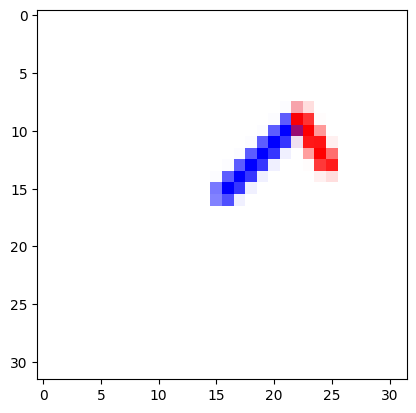

In [41]:
# choose dummy link angles
_th = jnp.array([jnp.pi / 4, -jnp.pi / 3])

# render robot configuration as a BGR image
_img = render_robot_configuration(ROBOT_PARAMS, _th)
# transform image from BGR to RGB
_img_rbg = cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)

# print(_img.shape)
# print(_img)

# show image using Matplotlib
# plt.axis("off")
plt.imshow(_img)
plt.savefig(str(outputs_dir / "task_2b_dummy_rendering.pdf"))
plt.show()



Next, please complete `sense_link_angles(.)`, which shall given a trained CNN and an image estimate the link angles $\hat{\theta}$. This implementation consists of the following steps:

1. Transpose and reshape the image to the shape (batch, channels, height, width).
2. Load the image from the numpy array into a `torch.Tensor` of type `float32`.
3. Evaluate the CNN for the given torch image tensor and cast the output back into numpy.
4. Assign the JAX array of shape (2, ) containing the link angles to the variable `th_est`. Remember that the neural network will output the sequence $[\sin{\hat{\theta}_1}, \sin{\hat{\theta}_2}, \cos{\hat{\theta}_1}, \cos{\hat{\theta}_2}] \in \mathbb{R}^4$.

In [42]:
def sense_link_angles(sensing_model: nn.Module, img: onp.ndarray) -> Array:
    """
    Use trained CNN to sense link angles from rendered image.
    Args:
        sensing_model: PyTorch CNN model for sensing
        img: image of robot of shape (32, 32, 3)
    Returns:
        th_est: estimated link angles of shape (2,)
    """
    th_est = jnp.zeros((2,))
    # YOUR CODE HERE
    # raise NotImplementedError()

    img = img.astype(onp.float32)
    img = onp.swapaxes(onp.swapaxes(img,1,2),0,1)/255.0
    img = torch.from_numpy(img)
    img = torch.stack([img])
    # print(img.shape)
    out = sensing_model(img)
    theta1 = torch.atan2(out[0,0], out[0,2])
    theta2 = torch.atan2(out[0,1], out[0,3])

    # out = out.data.numpy()
    
    th_est = jnp.array([theta1.data.numpy(), theta2.data.numpy()])

    return th_est

Now, we please load the saved neural network from Task 1.4 and activate the evaluation mode. **Please copy the (best-performing) model from the `assignment/problem_1/statedicts` to the `assignment/problem_2/statedicts` folder and specify the filename in the cell below.**

In [43]:
# Load the model
model_cnn_filename = "xyz.pt"
# YOUR CODE HERE
# raise NotImplementedError()

# the model will be accessed in the directory `assignment/problem_2/statedicts`
model_cnn_path = Path("statedicts") / model_cnn_filename
model_cnn = torch.jit.load(str(model_cnn_path))

# Activate evaluation model
model_cnn.eval()

RecursiveScriptModule(
  original_name=NeuralNetworkCNN
  (model): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=MaxPool2d)
    (3): RecursiveScriptModule(original_name=Conv2d)
    (4): RecursiveScriptModule(original_name=ReLU)
    (5): RecursiveScriptModule(original_name=MaxPool2d)
    (6): RecursiveScriptModule(original_name=Flatten)
    (7): RecursiveScriptModule(original_name=Linear)
    (8): RecursiveScriptModule(original_name=ReLU)
    (9): RecursiveScriptModule(original_name=Linear)
  )
)

In [44]:
# img = _img
# img = img.astype(onp.float32)
# img = onp.swapaxes(onp.swapaxes(img,1,2),0,1)/255.0
# img = torch.from_numpy(img)
# img = torch.stack([img])
# print(img.shape)
# print(img.type)
# out = model_cnn(img)
# # out = out.data.numpy()
# print(out)

# theta1 = torch.atan2(out[0,0], out[0,2])
# theta2 = torch.atan2(out[0,1], out[0,3])
# th_est = jnp.array([theta1.data.numpy(), theta2.data.numpy()])


In [45]:
# send dummy image through the model
_th_est = sense_link_angles(model_cnn, _img)

# comparing the estimated with the ground-truth link angles
print("Ground-truth link angles:", _th, "rad")
print("Estimated link angles:", _th_est, "rad")

Ground-truth link angles: [ 0.78539816 -1.04719755] rad
Estimated link angles: [ 0.84080327 -1.0634954 ] rad


Please implement below the code executed at each time-step of the simulation. You can take inspiration from the `jax_double_pendulum/robot_simulation.py` file. Your implementation should contain the following steps:

1. Evaluate the feed-forward and the feedback controllers `ctrl_ff` and `ctrl_fb` at the _estimated_ link angles `th_est`. **Please note that if you evaluate the controllers at the _actual_ link angles `th` instead, you will receive zero points for this task.**
2. Then, call the `discrete_forward_dynamics_fn` on the _actual_ system state to receive the system state at the next time step.
3. Next, render an image of the robot at the next time step.
4. Use that image to estimate the link angles at the next time-step using the CNN and save the result in the `th_next_est` variable.
5. Finally, compute the forward kinematics at the next estimated link angles `th_next_est` and save the elbow and end-effector positions into the variables `x_eb_next_est` and `x_next_est`.

In [46]:
def simulation_with_sensing_iteration(
    rp: Dict,
    dt: Array,
    sensing_model: nn.Module,
    discrete_forward_dynamics_fn: Callable,
    th: Array,
    th_est: Array,
    th_d: Array,
    tau_ext: Array,
    th_des: Array,
    th_d_des: Array,
    th_dd_des: Array,
    ctrl_ff: Callable,
    ctrl_fb: Callable,
) -> Tuple[
    Array,
    Array,
    Array,
    Array,
    Array,
    Array,
    Array,
    Array,
    Array,
    Array,
    Array,
    Array,
    Array,
]:
    """
    Simulates the double pendulum robot for one time step while integrating sensing using a trained CNN
    Args:
        rp: dictionary of robot parameters
        dt: time step between the current and the next state [s]
        sensing_model: PyTorch CNN model for sensing
        discrete_forward_dynamics_fn: function that computes the discrete forward dynamics.
            Given the time step dt, the current link state (th, th_d), and the link torque tau,
            it needs to return the next link state (th, th_d) and the link angular acceleration th_dd.
            It must have the signature: discrete_forward_dynamics_fn(dt, th, th_d, tau) -> (th_next, th_d_next, th_dd)
        th: ground-truth link angles of shape (2, )
        th_est: estimated link angles of shape (2, )
        th_d: ground-truth link angular velocities of shape (2, )
        tau_ext: link torques of shape (2, )
            which are applied to the system in addition to the evaluated feedforward and feedback torques
        th_des: desired link angles of shape (2, )
        th_d_des: desired link angular velocities of shape (2, )
        th_dd_des: desired link angular accelerations of shape (2, )
        ctrl_ff: callable computing the feed-forward control torques. Needs to return jax.array of shape (2, )
            It must have the signature: ctrl_ff(th, th_d, th_des, th_d_des, th_dd_des) -> tau_ff
        ctrl_fb: callable computing the feed-back control torques. Needs to return jax.array of shape (2, )
            It must have the signature: ctrl_fb(th, th_d, th_des, th_d_des) -> tau_fb

    Returns:
        th_next: next link angles of shape (2, )
        th_next_est: next estimated link angles of shape (2, )
        th_d_next: next link angular velocities of shape (2, )
        th_dd: link angular accelerations of shape (2, )
        x_next: next end-effector position of shape (2, )
        x_next_est: next estimated end-effector position of shape (2, )
        x_d_next: next end-effector velocity of shape (2, )
        x_dd: end-effector acceleration of shape (2, )
        x_eb_next: next position of elbow joint of shape (2, )
        x_eb_next_est: next estimated position of elbow joint of shape (2, )
        tau: total external torque applied to the links of shape (2, )
        tau_ff: torque computed by feed-forward controller of shape (2, )
        tau_fb: torque computed by feedback controller of shape (2, )
    """
    # evaluate feedforward and feedback controllers at the estimated link angles
    # Hint: check the implementation in `jax_double_pendulum.robot_simulation`
    tau_ff = jnp.zeros_like(tau_ext)
    tau_fb = jnp.zeros_like(tau_ext)
    # YOUR CODE HERE
    # raise NotImplementedError()
    tau_ff = ctrl_ff(th_est, th_d, th_des, th_d_des, th_dd_des)
    tau_fb = ctrl_fb(th_est, th_d, th_des, th_d_des)
    tau = tau_ext + tau_ff + tau_fb

    # evaluate the dynamics at the ground-truth state
    th_next = jnp.zeros_like(th)
    th_d_next = jnp.zeros_like(th_d)
    th_dd = jnp.zeros_like(th)
    # YOUR CODE HERE
    # raise NotImplementedError()
    th_next, th_d_next, th_dd = discrete_forward_dynamics_fn(rp, dt, th, th_d, tau)


    # evaluate forward kinematics at the ground-truth state of the next time-step
    x_next, x_d_next, x_dd, x_eb_next = extended_forward_kinematics(
        rp, th_next, th_d_next, th_dd
    )

    # render robot configuration for the next ground-truth link angles
    # YOUR CODE HERE
    # raise NotImplementedError()
    img = render_robot_configuration(ROBOT_PARAMS, th_next)


    # estimate the next link angles from the rendered image
    th_next_est = jnp.zeros_like(th_next)
    # YOUR CODE HERE
    # raise NotImplementedError()
    th_next_est = sense_link_angles(sensing_model, img)



    # make sure that the estimated link angles are in the range [-pi, pi]
    th_next_est = th_est + normalize_link_angles(th_next_est - th_est)

    # evaluate forward kinematics for the next estimated link angles
    # i.e. estimate the next elbow joint position `x_eb_next_est`,
    # and the next end-effector position `x_next_est`
    x_eb_next_est, x_next_est = jnp.zeros_like(x_eb_next), jnp.zeros_like(x_next)
    # YOUR CODE HERE
    # raise NotImplementedError()
    x_eb_next_est, x_next_est = forward_kinematics(rp, th_next_est)

    return (
        th_next,
        th_next_est,
        th_d_next,
        th_dd,
        x_next,
        x_next_est,
        x_d_next,
        x_dd,
        x_eb_next,
        x_eb_next_est,
        tau,
        tau_ff,
        tau_fb,
    )

Finally, we design the simulation loop. Please implement the the estimation of the link angles for the first time-step with index 0.

In [47]:
def simulate_robot_with_sensing(
    rp: dict,
    t_ts: jnp.ndarray,
    sensing_model: nn.Module,
    discrete_forward_dynamics_fn: Callable = None,
    th_0: jnp.ndarray = jnp.array([0.0, 0.0]),
    th_d_0: jnp.ndarray = jnp.array([0.0, 0.0]),
    tau_ext_ts: jnp.ndarray = None,
    th_des_ts: jnp.ndarray = None,
    th_d_des_ts: jnp.ndarray = None,
    th_dd_des_ts: jnp.ndarray = None,
    ctrl_ff: Callable = lambda th, th_d, th_des, th_d_des, th_dd_des: jnp.zeros((2,)),
    ctrl_fb: Callable = lambda th, th_d, th_des, th_d_des: jnp.zeros((2,)),
) -> Dict[str, jnp.ndarray]:
    """
    Simulates the double pendulum robot with sensing.

    Args:
        rp: dictionary of robot parameters
        t_ts: time steps of the trajectory [s] of shape (num_time_steps, )
        sensing_model: PyTorch CNN model for sensing
        discrete_forward_dynamics_fn: function that computes the discrete forward dynamics.
            Given the time step dt, the current link state (th, th_d), and the link torque tau,
            it needs to return the next link state (th, th_d) and the link angular acceleration th_dd.
            It must have the signature: discrete_forward_dynamics_fn(dt, th, th_d, tau) -> (th_next, th_d_next, th_dd)
        th_0: initial link angles of shape (2, )
        th_d_0: initial link angular velocities of shape (2, )
        tau_ext_ts: link torques of shape (num_time_steps, 2)
            which are applied to the system in addition to the evaluated feedforward and feedback torques
        th_des_ts: desired link angles of shape (num_time_steps, 2)
        th_d_des_ts: desired link angular velocities of shape (num_time_steps, 2)
        th_dd_des_ts: desired link angular accelerations of shape (num_time_steps, 2)
        ctrl_ff: callable computing the feed-forward control torques. Needs to return jax.array of shape (2, )
            It must have the signature: ctrl_ff(th, th_d, th_des, th_d_des, th_dd_des) -> tau_ff
        ctrl_fb: callable computing the feed-back control torques. Needs to return jax.array of shape (2, )
            It must have the signature: ctrl_fb(th, th_d, th_des, th_d_des) -> tau_fb

    Returns:
        sim_ts: dictionary of states and other time series data of simulation
    """
    if discrete_forward_dynamics_fn is None:
        discrete_forward_dynamics_fn = partial(discrete_forward_dynamics, rp)

    if tau_ext_ts is None:
        tau_ext_ts = jnp.zeros((t_ts.shape[0], 2))

    if th_des_ts is None:
        th_des_ts = jnp.zeros((t_ts.shape[0], 2))

    if th_d_des_ts is None:
        th_d_des_ts = jnp.zeros((t_ts.shape[0], 2))

    if th_dd_des_ts is None:
        th_dd_des_ts = jnp.zeros((t_ts.shape[0], 2))

    num_time_steps = t_ts.shape[0]

    # initialize diagnostic dictionary of system states over the trajectory
    sim_ts = dict(
        t_ts=t_ts,
        th_ts=jnp.zeros((num_time_steps, 2)),
        th_est_ts=jnp.zeros((num_time_steps, 2)),
        th_d_ts=jnp.zeros((num_time_steps, 2)),
        th_dd_ts=jnp.zeros((num_time_steps, 2)),
        x_ts=jnp.zeros((num_time_steps, 2)),
        x_est_ts=jnp.zeros((num_time_steps, 2)),
        x_d_ts=jnp.zeros((num_time_steps, 2)),
        x_dd_ts=jnp.zeros((num_time_steps, 2)),
        x_eb_ts=jnp.zeros((num_time_steps, 2)),
        x_eb_est_ts=jnp.zeros((num_time_steps, 2)),
        tau_ts=jnp.zeros((num_time_steps, 2)),
        tau_ff_ts=jnp.zeros((num_time_steps, 2)),
        tau_fb_ts=jnp.zeros((num_time_steps, 2)),
    )

    # evaluate quantities at initial state
    sim_ts["th_ts"] = sim_ts["th_ts"].at[0].set(th_0)
    sim_ts["th_d_ts"] = sim_ts["th_d_ts"].at[0].set(th_d_0)
    x_0, x_d_0, x_dd_0, x_eb_0 = extended_forward_kinematics(
        rp, th_0, th_d_0, th_dd=jnp.zeros((2,))
    )
    sim_ts["x_ts"] = sim_ts["x_ts"].at[0].set(x_0)
    sim_ts["x_d_ts"] = sim_ts["x_d_ts"].at[0].set(x_d_0)
    sim_ts["x_dd_ts"] = sim_ts["x_dd_ts"].at[0].set(x_dd_0)
    sim_ts["x_eb_ts"] = sim_ts["x_eb_ts"].at[0].set(x_eb_0)

    # estimate link angles, elbow and end-effector positions at the initial state
    th_est_0 = jnp.zeros_like(th_0)
    x_eb_est_0 = jnp.zeros_like(x_0)
    x_est_0 = jnp.zeros_like(x_eb_0)
    # YOUR CODE HERE
    # raise NotImplementedError()

    img = render_robot_configuration(ROBOT_PARAMS, th_0)
    th_est_0 = sense_link_angles(sensing_model, img)
    x_eb_est_0, x_est_0 = forward_kinematics(rp, th_est_0)

    sim_ts["th_est_ts"] = sim_ts["th_est_ts"].at[0].set(th_est_0)
    sim_ts["x_eb_est_ts"] = sim_ts["x_eb_est_ts"].at[0].set(x_eb_est_0)
    sim_ts["x_est_ts"] = sim_ts["x_est_ts"].at[0].set(x_est_0)

    for time_idx in (pbar := tqdm(range(1, num_time_steps))):
        dt = t_ts[time_idx] - t_ts[time_idx - 1]
        (
            th,
            th_est,
            th_d,
            th_dd,
            x,
            x_est,
            x_d,
            x_dd,
            x_eb,
            x_eb_est,
            tau,
            tau_ff,
            tau_fb,
        ) = simulation_with_sensing_iteration(
            rp,
            dt,
            sensing_model,
            discrete_forward_dynamics_fn,
            sim_ts["th_ts"][time_idx - 1],
            sim_ts["th_est_ts"][time_idx - 1],
            sim_ts["th_d_ts"][time_idx - 1],
            tau_ext_ts[time_idx - 1],
            th_des_ts[time_idx],
            th_d_des_ts[time_idx],
            th_dd_des_ts[time_idx],
            ctrl_ff,
            ctrl_fb,
        )
        sim_ts["th_ts"] = sim_ts["th_ts"].at[time_idx].set(th)
        sim_ts["th_est_ts"] = sim_ts["th_est_ts"].at[time_idx].set(th_est)
        sim_ts["th_d_ts"] = sim_ts["th_d_ts"].at[time_idx].set(th_d)
        sim_ts["th_dd_ts"] = sim_ts["th_dd_ts"].at[time_idx].set(th_dd)
        sim_ts["x_ts"] = sim_ts["x_ts"].at[time_idx].set(x)
        sim_ts["x_est_ts"] = sim_ts["x_est_ts"].at[time_idx].set(x_est)
        sim_ts["x_d_ts"] = sim_ts["x_d_ts"].at[time_idx].set(x_d)
        sim_ts["x_dd_ts"] = sim_ts["x_dd_ts"].at[time_idx].set(x_dd)
        sim_ts["x_eb_ts"] = sim_ts["x_eb_ts"].at[time_idx].set(x_eb)
        sim_ts["x_eb_est_ts"] = sim_ts["x_eb_est_ts"].at[time_idx].set(x_eb_est)
        sim_ts["tau_ts"] = sim_ts["tau_ts"].at[time_idx - 1].set(tau)
        sim_ts["tau_ff_ts"] = sim_ts["tau_ff_ts"].at[time_idx - 1].set(tau_ff)
        sim_ts["tau_fb_ts"] = sim_ts["tau_fb_ts"].at[time_idx - 1].set(tau_fb)

    return sim_ts

## Simulating the closed-loop system (10p)

Please simulate the closed-loop system using the PD + feedforward controller from task 2a.3 for regulating the system to follow the given ellipse trajectory. However, now the controller (both feed-forward and feedback) will use the estimated link angles instead of the actual ones. You are free to tune the feedback gains of the PD controller yourself to achieve the best possible performance for your trained sensing CNN.

You will receive 2 points for your implementation (i.e. if your code runs through without any errors). The remaining 8 points are attributed based on the performance of your closed-loop control system. You will receive the full 8 performance points if the Euclidean norm of the RMSE of the end-effector position between the reference trajectory and the actual (i.e. not estimated) robot evolution is **below** 0.5 m. If the error is between 0.5 m and 1.5 m, your grade will be linarly scaled with the error. However, if the error is larger than 1.5 m, you will not receive any credits for the control performance.

In [48]:
# simulation parameters
sim_duration = 5.0  # [s]
sim_dt = 1e-2  # [s]

# define time steps
t_ts = sim_dt * jnp.arange(int(sim_duration / sim_dt))

# generate trajectory
traj_ts = generate_ellipse_trajectory(
    rp=ROBOT_PARAMS,
    t_ts=t_ts,
    **ELLIPSE_PARAMS,
)

# initial link angles (i.e. at the first time-step)
th_0 = traj_ts["th_ts"][0] - jnp.array([0.1, 0.2])

In [49]:
# import PD feedback and PD + feedforward controllers from controllers.ipynb
from ipynb.fs.full.controllers import ctrl_fb_pd, ctrl_ff_feedforward

# construct feedforward controller
ctrl_ff = None
# YOUR CODE HERE
# raise NotImplementedError()
ctrl_ff = partial(ctrl_ff_feedforward, partial(dynamical_matrices, ROBOT_PARAMS))

# controller parameters
# define the proportional gain matrix kp and the derivative gain matrix kd
kp = 500 * jnp.eye(2)  # [Nm/rad]
kd = 50 * jnp.eye(2)  # [Nm s/rad]

# simulate the robot with the given controller
# save the simulation date in `sim_ts`

# YOUR CODE HERE
# raise NotImplementedError()
sim_ts = simulate_robot_with_sensing(
    rp=ROBOT_PARAMS,
    t_ts=t_ts,
    sensing_model=model_cnn,
    discrete_forward_dynamics_fn=discrete_forward_dynamics,
    th_0=th_0,
    th_d_0=traj_ts["th_d_ts"][0],
    tau_ext_ts = None,
    th_des_ts=traj_ts["th_ts"],
    th_d_des_ts=traj_ts["th_d_ts"],
    th_dd_des_ts=traj_ts["th_dd_ts"],
    ctrl_ff=ctrl_ff,
    ctrl_fb=partial(ctrl_fb_pd, kp=kp, kd=kd),
    )   



# evaluate the control performance quantitatively
rmse_th, rmse_th_d, rmse_th_dd = compute_configuration_space_rmse(traj_ts, sim_ts)
rmse_x, rmse_x_d, rmse_x_dd = compute_operational_space_rmse(traj_ts, sim_ts)
with jnp.printoptions(precision=3):
    print(
        "RMSE theta:",
        rmse_th,
        "rad, RMSE theta_d:",
        rmse_th_d,
        "rad/s, RMSE theta_dd:",
        rmse_th_dd,
        "rad/s^2",
    )
    print(
        "RMSE x:",
        f"{jnp.linalg.norm(rmse_x):.4f}",
        "m, RMSE x_d:",
        f"{jnp.linalg.norm(rmse_x_d):.3f}",
        "m/s, RMSE x_dd:",
        f"{jnp.linalg.norm(rmse_x_dd):.2f}",
        "m/s^2",
    )

  0%|          | 0/499 [00:00<?, ?it/s]

RMSE theta: [0.071 0.086] rad, RMSE theta_d: [0.19 0.56] rad/s, RMSE theta_dd: [ 1.681 10.993] rad/s^2
RMSE x: 0.1352 m, RMSE x_d: 0.605 m/s, RMSE x_dd: 8.95 m/s^2


In [50]:
# DO NOT REMOVE OR MODIFY THIS CELL

rmse_th, rmse_th_d, rmse_th_dd = compute_configuration_space_rmse(traj_ts, sim_ts)
rmse_x, rmse_x_d, rmse_x_dd = compute_operational_space_rmse(traj_ts, sim_ts)

grader_max_impl_points = 2  # points for a correct implementation
grader_max_perf_points = 8  # points for a good control performance

rmse_x_norm = jnp.linalg.norm(rmse_x)  # achieved RMSE in operational space
rmse_x_lb = 0.5  # m --> this will result in the full grade for the control performance
rmse_x_ub = 1.5  # m --> this will result in zero points for the control performance

grader_perf_points = grader_max_perf_points * (
    (1 - (rmse_x_norm - rmse_x_lb) / (rmse_x_ub - rmse_x_lb))
)
grader_perf_points = jnp.clip(grader_perf_points, 0, grader_max_perf_points).item()

grader_points = grader_max_impl_points + grader_perf_points

print(
    f"If you submit the assignment as it is, you will receive {grader_points} points."
)


grader_points

If you submit the assignment as it is, you will receive 10.0 points.


10.0

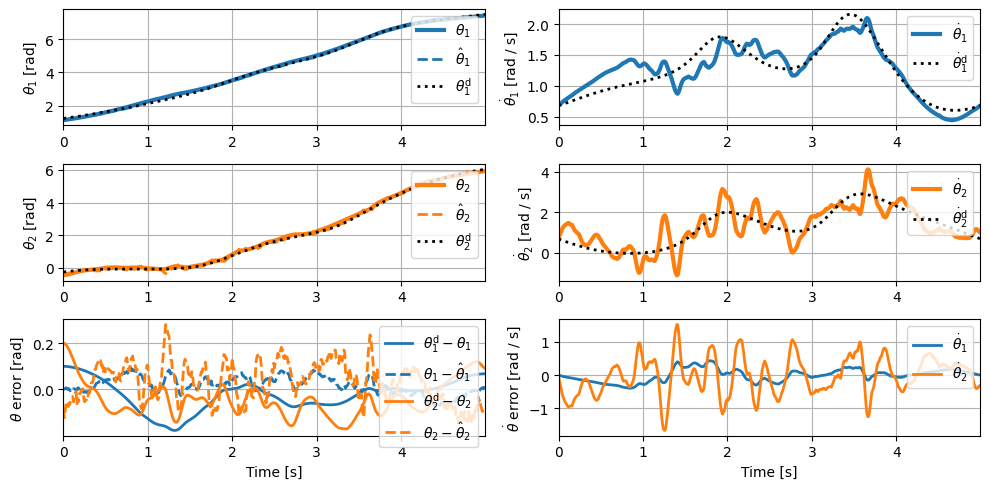

In [51]:
# plot the configuration-space evolution
plot_configuration_space_trajectory_following(
    traj_ts,
    sim_ts,
    filepath=str(outputs_dir / "task_2b_configuration_space_trajectory_following.pdf"),
)

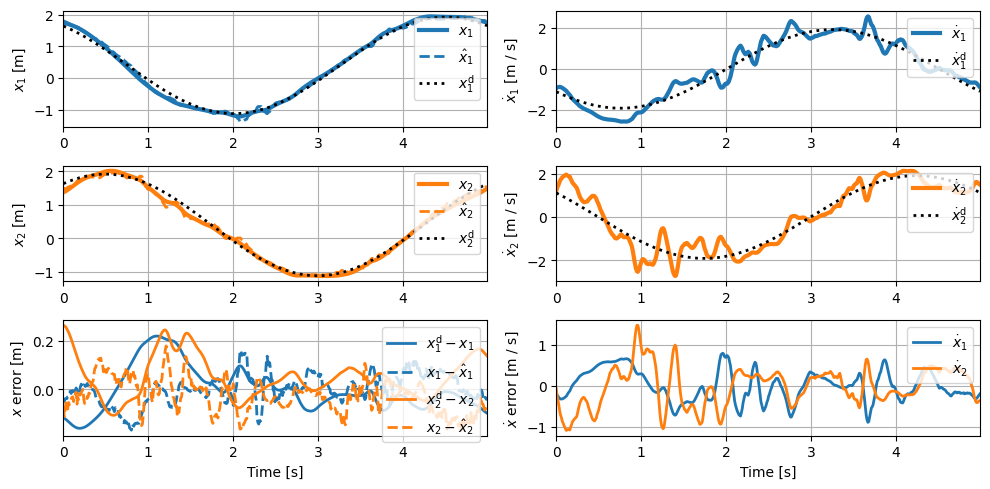

In [52]:
# plot the operational-space evolution
plot_operational_space_trajectory_following(
    traj_ts,
    sim_ts,
    filepath=str(outputs_dir / "task_2b_operational_space_trajectory_following.pdf"),
)

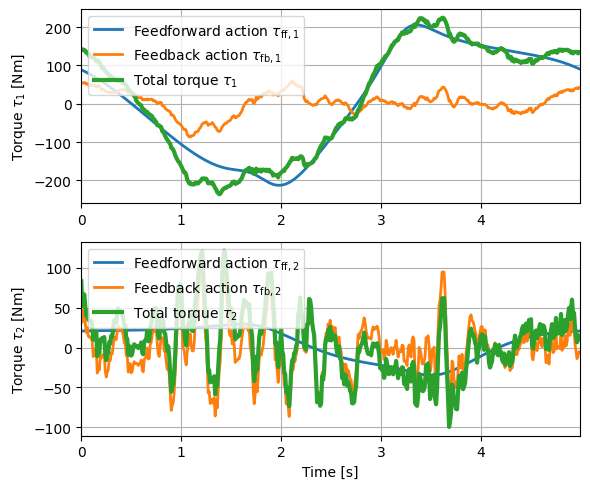

In [53]:
# plot the actuation sequence
plot_actuation(sim_ts, filepath=str(outputs_dir / "task_2b_actuation.pdf"))

In [54]:
if not AUTOGRADING:
    sim_hat_ts = {
        "x_ts": sim_ts["x_est_ts"],
        "x_eb_ts": sim_ts["x_eb_est_ts"],
    }
    ani = animate_robot(
        ROBOT_PARAMS,
        traj_ts=traj_ts,
        sim_ts=sim_ts,
        sim_hat_ts=sim_hat_ts,
        step_skip=5,
        show=False,
        filepath=str(outputs_dir / "task_2b_controlled_robot.mp4"),
    )
    display(HTML(ani.to_html5_video()))